In [30]:
sc.version

2.4.4

### Sample Dataset - customer.txt and sales.txt

In [139]:
case class Customer(id: String, name: String, address: String, zip: String) {  //case class Customer(_1:String,_2:String,_3:String,_4:String)
  val city = address.split(' ').last
}

import java.util.Date
case class CustomerOrder(private val timeStamp: Long, customerId: String, sales: Double) { //case class CustomerOrder(_1:Long,_2:String,_3:Double)
  val date = new Date(timeStamp * 1000)
}

//RDD
val customerFileRdd = sc.textFile("customer.txt")
//println("CustomerRDD:\n"+customerFileRdd.collect.mkString("#   "))
customerFileRdd.collect().foreach(println)
val salesFileRdd = sc.textFile("sales.txt")
//println("SalesRDD:\n"+salesFileRdd.collect.mkString(", "))
salesFileRdd.collect().foreach(println)


123,AAA Inc,1 First Ave Mountain View CA,94040
456,ABC Inc,2 First Ave Fayetteville AK,72703
789,DEF Inc,3 First Ave Mobile AL,36571
101112,GHI Inc,4 First Ave Portland OR,97205
1470045600,456,123458
1454313600,123,123456
1470049200,789,123459
1501578000,789,123457
1470049201,789,223459


defined class Customer
defined class CustomerOrder
customerFileRdd = customer.txt MapPartitionsRDD[265] at textFile at <console>:28
salesFileRdd = sales.txt MapPartitionsRDD[267] at textFile at <console>:31


sales.txt MapPartitionsRDD[267] at textFile at <console>:31

## Map
Return a new RDD by applying a function to each element of this RDD.

In [32]:
val customerTable = customerFileRdd.flatMap(x => x.split('\n'))
                                   .map(y => y.split(','))
                                   .map(z => (z(0), Customer(z(0), z(1), z(2), z(3))))
customerTable.collect()

customerTable = MapPartitionsRDD[83] at map at <console>:39


Array((123,Customer(123,AAA Inc,1 First Ave Mountain View CA,94040)), (456,Customer(456,ABC Inc,2 First Ave Fayetteville AK,72703)), (789,Customer(789,DEF Inc,3 First Ave Mobile AL,36571)), (101112,Customer(101112,GHI Inc,4 First Ave Portland OR,97205)))

In [55]:
val salesTable = salesFileRdd.map(x => {
    val z = x.split(',')
    (z(1), CustomerOrder(z(0).toLong, z(1), z(2).toDouble))
  })
salesTable.collect()

salesTable = MapPartitionsRDD[106] at map at <console>:37


Array((456,CustomerOrder(1470045600,456,123458.0)), (123,CustomerOrder(1454313600,123,123456.0)), (789,CustomerOrder(1470049200,789,123459.0)), (789,CustomerOrder(1501578000,789,123457.0)), (789,CustomerOrder(1470049201,789,223459.0)))

## JOIN - union(otherRDD, numPartitions=None) 
Return a new RDD containing all pairs of elements having the same key in the original RDDs


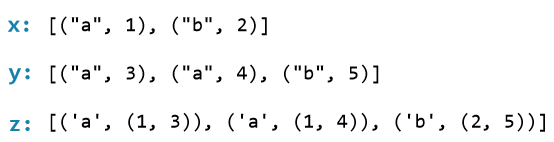

In [37]:
val joinedRdd = customerTable join salesTable
joinedRdd.collect()

joinedRdd = MapPartitionsRDD[92] at join at <console>:37


Array((123,(Customer(123,AAA Inc,1 First Ave Mountain View CA,94040),CustomerOrder(1454313600,123,123456.0))), (789,(Customer(789,DEF Inc,3 First Ave Mobile AL,36571),CustomerOrder(1470049200,789,123459.0))), (789,(Customer(789,DEF Inc,3 First Ave Mobile AL,36571),CustomerOrder(1501578000,789,123457.0))), (789,(Customer(789,DEF Inc,3 First Ave Mobile AL,36571),CustomerOrder(1470049201,789,223459.0))), (456,(Customer(456,ABC Inc,2 First Ave Fayetteville AK,72703),CustomerOrder(1470045600,456,123458.0))))

## ReduceByKey 
Group the values for each key in the original RDD. Create a new pair where the original key corresponds to this collected group of value

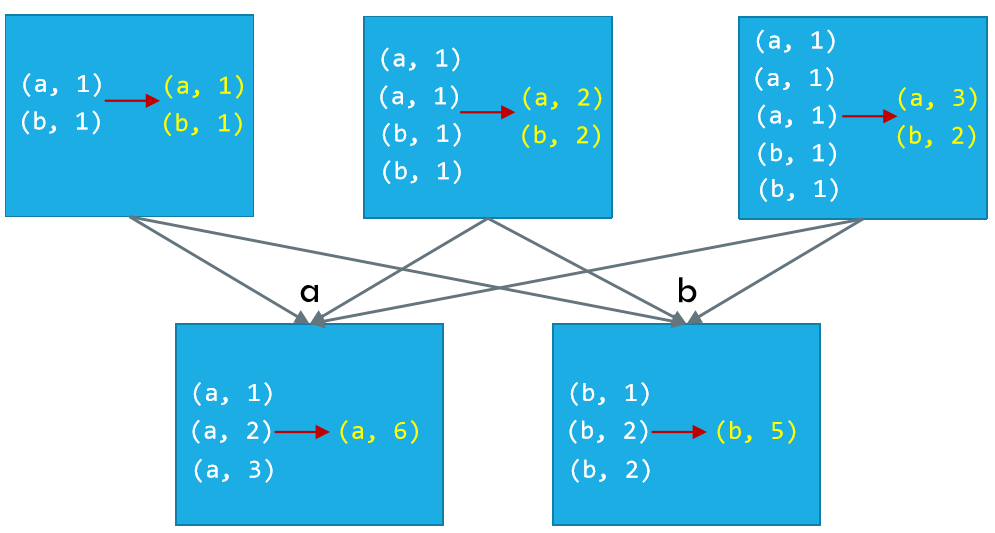

In [102]:
val yearlyReport = joinedRdd
      .map(joinedTuple => ((joinedTuple._2._1.city, joinedTuple._2._2.date.getYear + 1900, joinedTuple._1),joinedTuple._2._2.sales))
      .reduceByKey(_ + _)
      .map(deducedTuple => s"${deducedTuple._1._1},${deducedTuple._1._2},${deducedTuple._2}")

yearlyReport.collect()

yearlyReport = MapPartitionsRDD[176] at map at <console>:40


Array(AL,2017,123457.0, AK,2016,123458.0, AL,2016,346918.0, CA,2016,123456.0)

In [103]:
val monthlyReport = joinedRdd.
      map(joinedTuple => ((joinedTuple._2._1.city, joinedTuple._2._2.date.getYear + 1900, joinedTuple._2._2.date.getMonth + 1, joinedTuple._1),joinedTuple._2._2.sales))
      .reduceByKey(_ + _)
      .map(y => s"${y._1._1},${y._1._2},${y._1._3},${y._2}")
monthlyReport.collect()

monthlyReport = MapPartitionsRDD[179] at map at <console>:40


Array(AK,2016,8,123458.0, CA,2016,2,123456.0, AL,2016,8,346918.0, AL,2017,8,123457.0)

In [104]:
val dailyReport = joinedRdd
      .map(joinedTuple => ((joinedTuple._2._1.city, joinedTuple._2._2.date.getYear + 1900, joinedTuple._2._2.date.getMonth + 1, joinedTuple._2._2.date.getDate, joinedTuple._1),joinedTuple._2._2.sales))
      .reduceByKey(_ + _)
      .map(deducedTuple => s"${deducedTuple._1._1},${deducedTuple._1._2},${deducedTuple._1._3},${deducedTuple._1._3},${deducedTuple._2}")
dailyReport.collect()

dailyReport = MapPartitionsRDD[182] at map at <console>:38


Array(CA,2016,2,2,123456.0, AL,2017,8,8,123457.0, AL,2016,8,8,346918.0, AK,2016,8,8,123458.0)

## UNION - union(otherRDD)

Return a new RDD containing all items from two original RDDs. Duplicates are not culled



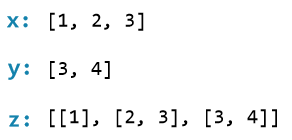

In [115]:
val collective = yearlyReport union monthlyReport union dailyReport map(x => {
      val city = x.split(',')(0)
      (city, x)
    })
collective.collect()

collective = MapPartitionsRDD[200] at map at <console>:41


Array((AL,AL,2017,123457.0), (AK,AK,2016,123458.0), (AL,AL,2016,346918.0), (CA,CA,2016,123456.0), (AK,AK,2016,8,123458.0), (CA,CA,2016,2,123456.0), (AL,AL,2016,8,346918.0), (AL,AL,2017,8,123457.0), (CA,CA,2016,2,2,123456.0), (AL,AL,2017,8,8,123457.0), (AL,AL,2016,8,8,346918.0), (AK,AK,2016,8,8,123458.0))

In [140]:
collective.sortBy(x => x._1).map(x => x._2).collect().foreach(println)

AK,2016,123458.0
AK,2016,8,123458.0
AK,2016,8,8,123458.0
AL,2017,123457.0
AL,2016,346918.0
AL,2016,8,346918.0
AL,2017,8,123457.0
AL,2017,8,8,123457.0
AL,2016,8,8,346918.0
CA,2016,123456.0
CA,2016,2,123456.0
CA,2016,2,2,123456.0


In [143]:
collective.sortBy(x => x._1).map(x => x._2).repartition(1).saveAsTextFile("file:///home/jovyan/finalOutputtest")

lastException: Throwable = null


In [141]:
sc.textFile("file:///home/jovyan/finalOutput").collect().foreach(println)

AK,2016,123458.0
AK,2016,8,123458.0
AK,2016,8,8,123458.0
AL,2017,123457.0
AL,2016,346918.0
AL,2016,8,346918.0
AL,2017,8,123457.0
AL,2017,8,8,123457.0
AL,2016,8,8,346918.0
CA,2016,123456.0
CA,2016,2,123456.0
CA,2016,2,2,123456.0
